In [22]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import json
import os
import math
import heapq
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cwd = os.getcwd()
print(cwd)

C:\Users\Jamie Wang\Documents\Duke\Senior\CS330\cs330-casestudy


# Load Data

In [3]:
adjacency_f = open(f'{cwd}/adjacency.json')
adjacency = json.load(adjacency_f)
node_f = open(f'{cwd}/node_data.json')
nodes = json.load(node_f)
nodes_df = pd.DataFrame(nodes).T

In [4]:
drivers = pd.read_csv(f'{cwd}/drivers.csv')
passengers = pd.read_csv(f'{cwd}/passengers.csv')

# Functions

In [5]:
def haversine_distance(lat1, lon1, lat2, lon2):
    '''
    Haversine distance metric between two points
    '''
    
    #earth radius in km
    radius = 6371.0

    #convert lat lon into radians from degress
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    #haversine from wikipedia
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c

    return distance

In [6]:
def get_nearest_node(lat, lon):
    '''
    Find nearest node via Haversine distance
    TODO: Find more efficient nearest node method
    '''
    min_dist = float('inf')
    nearest_node = ''
    for node in nodes:
        dist = haversine_distance(nodes[node]['lat'], nodes[node]['lon'], lat, lon)
        if dist < min_dist:
            min_dist = dist
            nearest_node = node
    return nearest_node

In [7]:
def get_datetime(time_string):
    '''
    Convert any datetime strings to datetime
    '''
    datetime_format = "%m/%d/%Y %H:%M:%S"
    time = datetime.strptime(time_string, datetime_format)
    return time

In [8]:
def djikstras(source, dest):
    '''
    Djikstra's algorithm
    Returns: dict of minimum distances to nodes and dict of node parents
    '''
    distance = {} #distances to each node
    parent = {} #
    
    #initialize all distances to infinity
    for node in nodes:
        distance[node] = float('inf')
    distance[source] = 0
    pq = [(0, source)]
    while pq:
        node_dist, node = heapq.heappop(pq)
        #TODO: stop when pop off destination node
        if node in adjacency:
            for neighbor in adjacency[node]:
                edge_dist = adjacency[node][neighbor]['time']
                #TODO: CHECK WEEKEND VS WEEKDAY TIMES
                if distance[neighbor] > node_dist+edge_dist:
                    distance[neighbor] = node_dist+edge_dist
                    parent[neighbor] = node
                    heapq.heappush(pq, (distance[neighbor], neighbor))
    return distance, parent

In [9]:
def get_path(parent, source_node, dest_node):
    '''
    Recover path using list of node parents, start at destination and end at source
    Returns: list of nodes in path (reverse order)
    '''
    path = [dest_node]
    current_node = dest_node
    while current_node != source_node:
        path.append(parent[current_node])
        current_node = parent[current_node]
    return path

In [90]:
def get_driver(p):
    '''
    Get the next driver from the driver PQ (Task 1 based on time)
    Update relevant driver and passenger variables and get the time to traverse from driver location to passenger pickup
    Returns: Driver match
    '''
    _, d = heapq.heappop(driver_q)
    #TODO: if driver not availalbe yet but is next available option, need to add that to wait time
    time, _ = djikstras(d.current_node, p.source_node)
    wait_time = time[p.source_node]
    d.current_node = p.source
    d.pickup_time += wait_time
    p.total_time += wait_time
    return d

In [28]:
def check_active(current_time, d):
    max_active_time = timedelta(hours=8) #check if driver has been active for over 8 hours, reference passenger appear for current time
    time_active = current_time - d.appear
    if time_active < max_active_time:
        return True #still active
    else:
        return False #driver is inactive

In [79]:
def ride():
    '''
    Main function for going through passenger and driver queues
    '''
    active_drivers = []
    completed_passengers = []
    completed_drivers = []
    passenger_times = []
    driver_profits = []
    
    while passenger_q:
        _, p = heapq.heappop(passenger_q) #get next passenger
        d = get_driver(p)
        active_drivers.append(d) #driver is now active (SHOULD CHANGE TO STATUS VARIABLE ASSOCIATED WITH DRIVER CLASS?)
        time, parent = djikstras(p.source_node, p.dest_node)
        ride_time = time[p.dest_node]
        p.total_time += ride_time
        completed_passengers.append(p)
        passenger_times.append(p.total_time)
        d.current_node = p.dest_node
        d.ride_time += ride_time
        current_time = timedelta(hours=p.total_time) + p.appear #get current time using total time waiting + riding by passenger
        if check_active(current_time, d):
            heapq.heappush(driver_q, (current_time, d))
            #TODO: TASK 2 CONCERN -> how to deal with case where driver is not available yet but passenger request ride and is nearest
       
        else:
            completed_drivers.append(d)
            driver_profits.append(d.get_profit())
    
    while driver_q:
        _, d = heapq.heappop(driver_q)
        completed_drivers.append(d)
        driver_profits.append(d.get_profit())
        
    return completed_passengers, completed_drivers, passenger_times, driver_profits

# Classes (Driver, Passenger)

In [97]:
class driver:
    def __init__(self, appear, source_lat, source_lon):
        self.appear = get_datetime(appear)
        self.source = (source_lat, source_lon)
        self.ride_time = 0 #total time logged driving passengers
        self.pickup_time = 0 #total time logged driving to passengers
        self.source_node = get_nearest_node(self.source[0], self.source[1])
        self.current_node = self.source_node #update as performing routes
        #TODO: add finish time (available + 8 hours)
    
    def get_profit(self):
        self.profit = self.ride_time - self.pickup_time
        return self.profit

In [92]:
class passenger:
    def __init__(self, appear, source_lat, source_lon, dest_lat, dest_lon):
        self.appear = get_datetime(appear)
        self.source = (source_lat, source_lon)
        self.dest = (dest_lat, dest_lon)
        self.total_time = 0 #total time logged for passenger (time appear to time drop off)
        self.source_node = get_nearest_node(self.source[0], self.source[1])
        self.dest_node = get_nearest_node(self.dest[0], self.dest[1])

# Run Task 1

In [100]:
#set up passenger q, NOTE: EXTREMELY SLOW (???), LIMIT QUEUE SIZE TO 10 FOR TESTING
passenger_q = []
for index, row in passengers.iloc[:2,:].iterrows():
    p = passenger(row['Date/Time'], row['Source Lat'], row['Source Lon'], row['Dest Lat'], row['Dest Lon'])
    heapq.heappush(passenger_q, (p.appear, p))
    
#set up driver q, NOTE: EXTREMELY SLOW (???), LIMIT QUEUE SIZE TO 10 FOR TESTING
driver_q = []
for index, row in drivers.iloc[:2,:].iterrows():
    d = driver(row['Date/Time'], row['Source Lat'], row['Source Lon'])
    heapq.heappush(driver_q, (d.appear, d))

In [101]:
completed_passengers, completed_drivers, passenger_times, driver_profits = ride()

In [102]:
passenger_times

[0.8268240442592348, 0.5954722148970512]

In [103]:
driver_profits

[-0.5252199718298928, 0.4173134184522186]

# Djikstra's Test
Single passenger and single driver

In [17]:
#test passenger
p1_test = passengers.iloc[0,:]
p1 = passenger(p1_test['Date/Time'], p1_test['Source Lat'], p1_test['Source Lon'], p1_test['Dest Lat'], p1_test['Dest Lon'])
print(vars(p1))

{'appear': datetime.datetime(2014, 4, 25, 0, 0), 'source': (40.6466, -73.7896), 'dest': (40.7603, -73.9794), 'total_time': inf, 'source_node': '599036657', 'dest_node': '42430361'}


In [25]:
#test driver
d1_test = drivers.iloc[0,:]
d1 = driver(d1_test['Date/Time'], d1_test['Source Lat'], d1_test['Source Lon'])
print(vars(d1))

{'appear': datetime.datetime(2014, 4, 25, 0, 14), 'source': (40.667, -73.8713), 'ride_time': inf, 'pickup_time': inf, 'source_node': '1942055181', 'current_node': '1942055181'}


https://docs.python.org/3/library/heapq.html
Heapq --> PQ implementation

https://builtin.com/software-engineering-perspectives/dijkstras-algorithm
Djikstras with heapq as PQ implementation

In [146]:
time, parent = djikstras(p1.source_node, p1.dest_node)
print('route time (hours):', time[p1.dest_node]) #get time from source to destination
path = get_path(parent, p1.source_node, p1.dest_node) #retrieve path from parent dict
path_coords = nodes_df[nodes_df.index.isin(path)] #retrieve path coordinates (to verify graphically)
print('path trajectory:')
print(path_coords.head(5))

route time (hours): 0.6220687313557267
path trajectory:
                  lon        lat
599140119  -73.797688  40.644869
280637036  -73.818879  40.707431
2799547029 -73.953619  40.741575
597311193  -73.928280  40.736499
455622434  -73.801249  40.667113


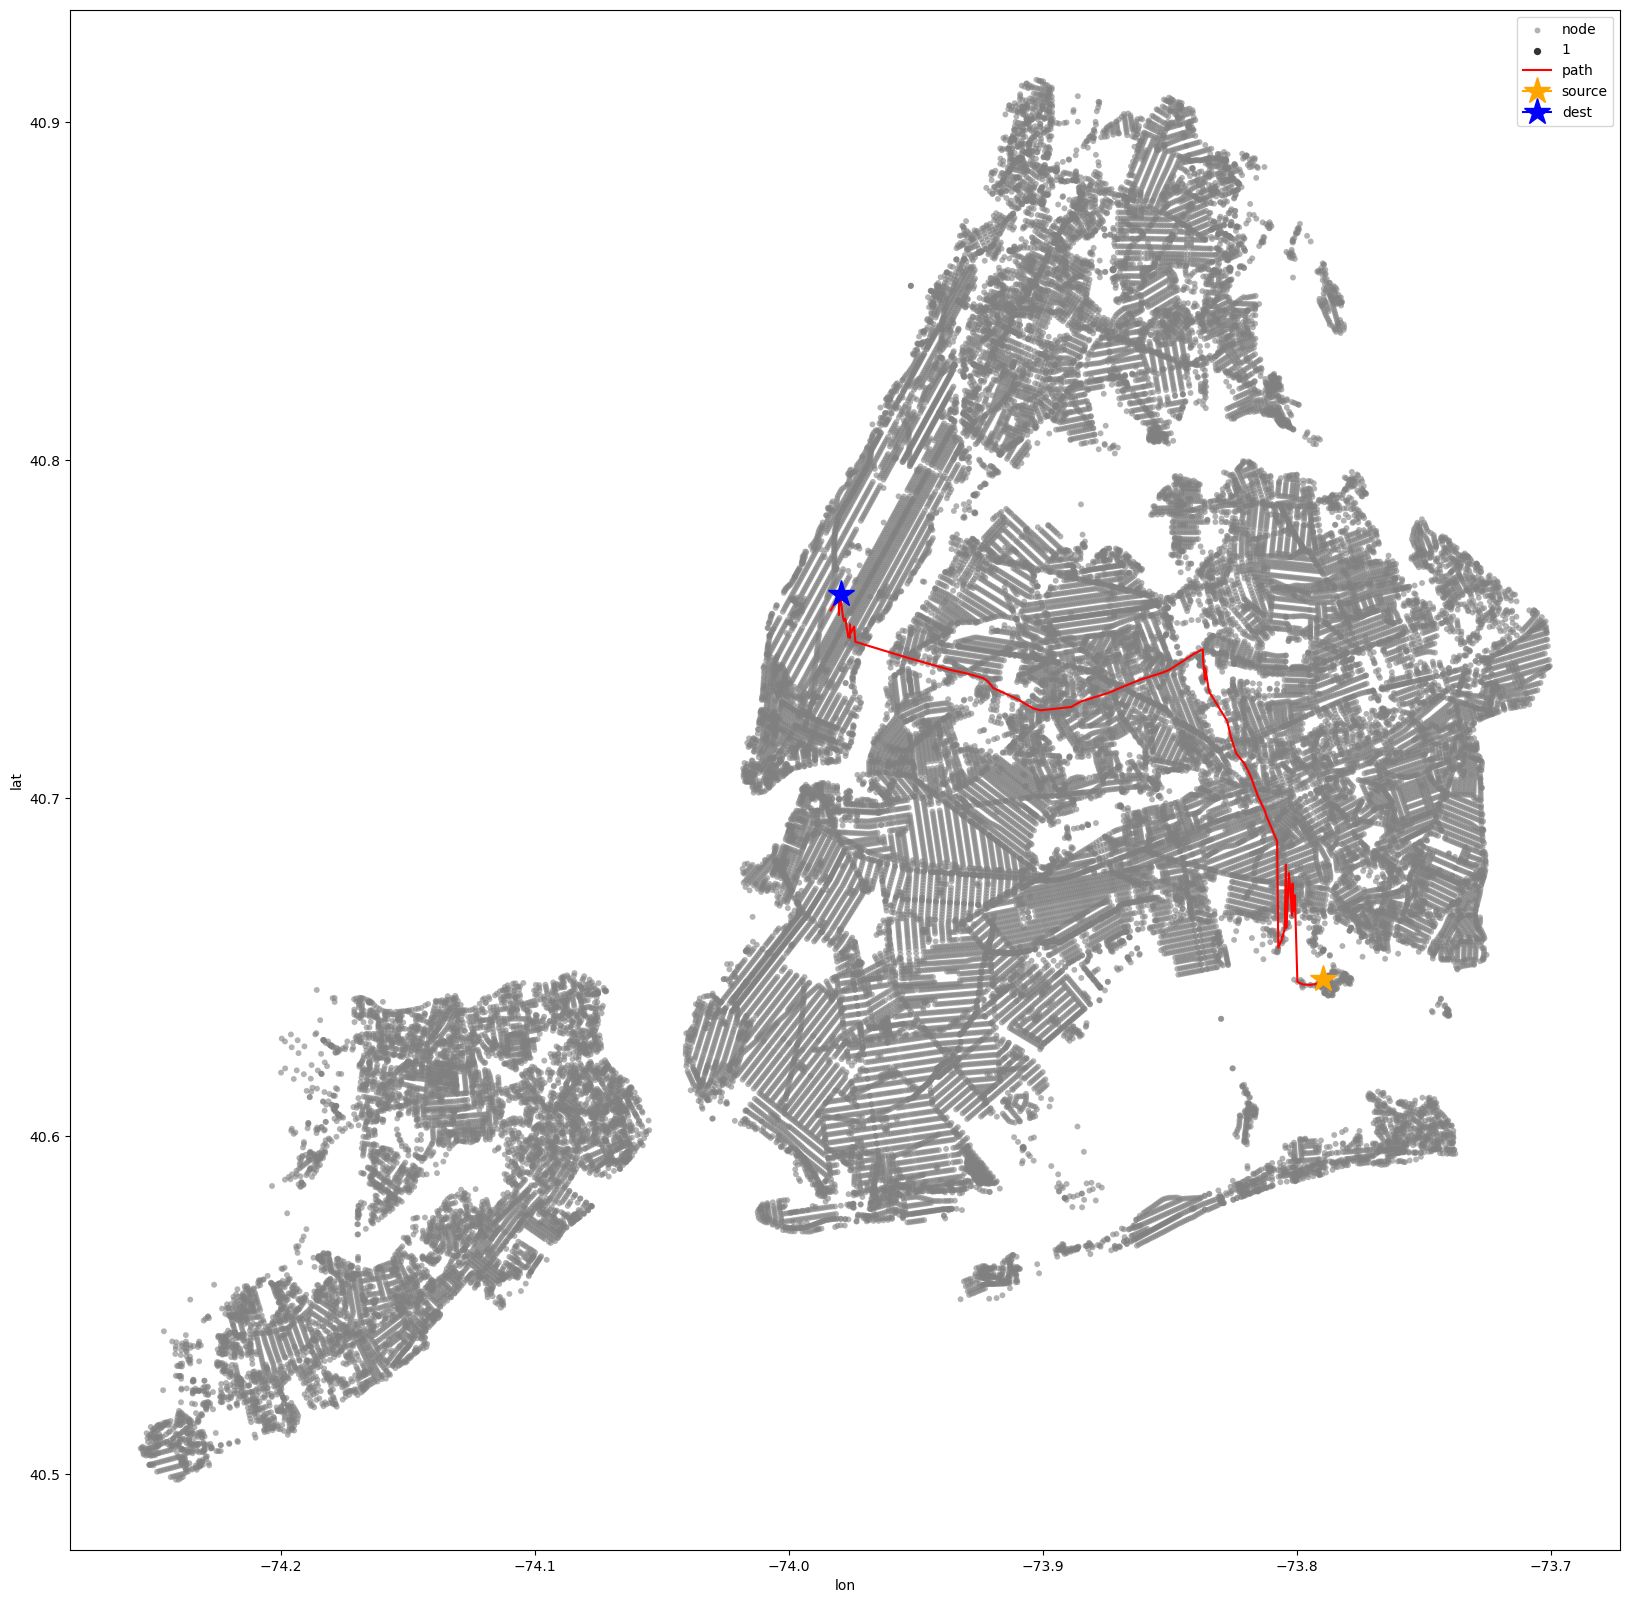

In [147]:
#plot nodes and path coords
plt.figure(figsize=(20, 20))
sns.scatterplot(nodes_df, x='lon', y='lat', size=1, alpha=0.6, linewidth=0, label='node', color='grey')
sns.lineplot(path_coords, x='lon', y='lat', color='red', alpha=1, label='path')
plt.plot([p1.source[1]], [p1.source[0]], marker='*', color='orange', markersize=20, label='source')
plt.plot([p1.dest[1]], [p1.dest[0]], marker='*', color='blue', markersize=20, label='dest')
plt.legend()